In [2]:
# Init
import glob
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing
import warnings

# Imports
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
# For loading data
import concurrent.futures
import gc
import json
import random

# Plotting imports
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy import concatenate as c
from numpy import cumsum

In [3]:
# Acc. functions
def returnLast(lst):
    return lst[-1]


def colorRanges(i):
    # Construct the colormap
    current_palette = sns.color_palette("muted", n_colors=5)
    cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
    # range and stuff
    if i == 0:
        return "0"
    elif i > 0 and i <= 20:
        return "1-20"
    elif i > 20 and i <= 50:
        return "20-50"
    elif i > 50 and i <= 100:
        return "50-100"
    elif i > 100 and i <= 200:
        return "100-200"
    elif i > 200 and i <= 300:
        return "200-300"
    elif i > 300:
        return ">300"


# Since pickle format is not working as intended.
# Insert angry thoughts abouts pickle format here
# A function to open pickle files and convert into json
def pickleToJson(resultDir):
    for file in glob.glob(os.path.join(resultDir, "*.pickle")):
        with open(file, "rb") as f:
            gc.disable()
            data = pickle.load(f)
            del data["TEset"]
            del data["NTE"]
            del data["NTI"]
            del data["AvgFit"]
            del data["Freq"]
            gc.enable()
            with open(file + ".json", "w") as fp:
                json.dump(data, fp)
    return 0

In [4]:
current_palette = sns.color_palette("muted", n_colors=5)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

In [5]:
# Path to results
resultDir = "/home/siddharth/git/Simulicron/Project_1C/etaVsTrSel/"

# Convert them to json
# returnValue = pickleToJson(resultDir)

In [6]:
# Read the json files into pandas dataframe
SimulationRecords = []
prob = 0.5
for filename in glob.glob(os.path.join(resultDir, "*.pickle.json")):
    with open(filename, "r") as file:
        jsonInMem = json.load(file)
        if jsonInMem["TRate"][0] == 0.5:
            SimulationRecords.append(jsonInMem)

SimulationResultsDataFrame = pd.DataFrame(SimulationRecords)

In [7]:
# Create a copy for inplace handling
resultDataframeC = SimulationResultsDataFrame.copy()

In [8]:
# Perform some data wrangling
resultDataframeC[["TranspositionRate_1", "TranspositionRate_2"]] = pd.DataFrame(
    resultDataframeC.TRate.tolist(), index=resultDataframeC.index
)
resultDataframeC[["TE_1_CN", "TE_2_CN"]] = resultDataframeC["TEfamilyCN"].apply(
    pd.Series
)
resultDataframeC[["TE_1_RG", "TE_2_RG"]] = resultDataframeC["TEfamilyRg"].apply(
    pd.Series
)
resultDataframeC[["TE_1_pi", "TE_2_pi"]] = resultDataframeC["TEpi"].apply(pd.Series)

# Add column for the last acn (average copy number) for each transposon family
resultDataframeC["TE_1_ACN"] = resultDataframeC["TE_1_CN"].apply(
    lambda x: returnLast(x)
)
resultDataframeC["TE_2_ACN"] = resultDataframeC["TE_2_CN"].apply(
    lambda x: returnLast(x)
)

# Add column for copies not present in clusters
resultDataframeC["TE_1_NCN"] = (
    resultDataframeC["TE_1_ACN"] - resultDataframeC["TE_1_pi"]
)
resultDataframeC["TE_2_NCN"] = (
    resultDataframeC["TE_2_ACN"] - resultDataframeC["TE_2_pi"]
)
resultDataframeC["TE_1_NCN_l"] = np.log(
    resultDataframeC["TE_1_ACN"] - resultDataframeC["TE_1_pi"]
)
resultDataframeC["TE_2_NCN_l"] = np.log(
    resultDataframeC["TE_2_ACN"] - resultDataframeC["TE_2_pi"]
)

# Add column for copy number ratio
resultDataframeC["(α/β) copy number"] = (
    resultDataframeC["TE_1_NCN"] / resultDataframeC["TE_2_NCN"]
)
resultDataframeC["log(α/dark2β) copy number"] = np.log(
    resultDataframeC["(α/β) copy number"]
)


# Get ranges for adding colors later
resultDataframeC["TE_1_NCN_R"] = resultDataframeC["TE_1_NCN"].apply(
    lambda x: colorRanges(x)
)
resultDataframeC["TE_2_NCN_R"] = resultDataframeC["TE_2_NCN"].apply(
    lambda x: colorRanges(x)
)

# Some wrangling for plotly go
x = resultDataframeC["ETA"]
y = resultDataframeC["selPen"]
TE1ACN = resultDataframeC["TE_1_ACN"]
TE2ACN = resultDataframeC["TE_2_ACN"]

# Convert count to log scale
resultDataframeC["TE_1_ACN_l"] = np.log(resultDataframeC["TE_1_ACN"])
resultDataframeC["TE_2_ACN_l"] = np.log(resultDataframeC["TE_2_ACN"])

# u2.eta
resultDataframeC["u2eta"] = resultDataframeC["TranspositionRate_2"] * (
    1 - resultDataframeC["ETA"]
)

/home/siddharth/mambaforge/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
alt.Chart(resultDataframeC).mark_circle(size=200).encode(
    x="u2eta:Q",
    y="TE_2_NCN:Q",
)

In [ ]:
# resultDataframeC1 = resultDataframeC[resultDataframeC['TE_2_NCN'] == 0]
alt.Chart(resultDataframeC).mark_circle(size=200).encode(
    x="ETA:Q",
    y="TranspositionRate_2:Q",
    color="TE_2_NCN",
)

In [ ]:
# resultDataframeC1 = resultDataframeC[resultDataframeC['TE_2_NCN'] == 0]
alt.Chart(resultDataframeC).mark_circle(size=200).encode(
    x="ETA:Q",
    y="TranspositionRate_2:Q",
    color="TE_2_NCN",
)

ValueError: Could not interpret value `log(α/β) copy number` for parameter `hue`

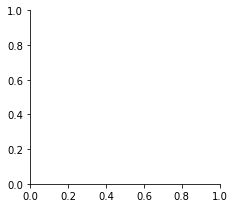

In [13]:
g = sns.FacetGrid(resultDataframeC, col="TranspositionRate_1", col_wrap=5, despine=True)
g.map_dataframe(
    sns.scatterplot,
    x="ETA",
    y="TranspositionRate_2",
    hue="log(α/β) copy number",
    s=70,
)
g.set_axis_labels("Co-regulation strength", "Transposition Rate 2")
g.add_legend()

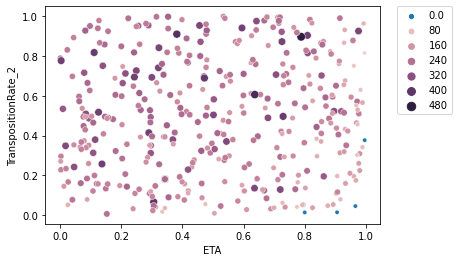

In [14]:
cmap = sns.cubehelix_palette(as_cmap=True)

resultDataframeC1 = resultDataframeC[resultDataframeC["TE_2_NCN"]==0]
sns.scatterplot(
    data=resultDataframeC1,
    x="ETA",
    y="TranspositionRate_2",
    hue="TE_2_NCN",
    size="TE_2_NCN",
)
resultDataframeC1 = resultDataframeC[resultDataframeC["TE_2_NCN"]!=0]
sns.scatterplot(
    data=resultDataframeC1,
    x="ETA",
    y="TranspositionRate_2",
    hue="TE_2_NCN",
    size="TE_2_NCN",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

<AxesSubplot:xlabel='u2eta', ylabel='TE_2_NCN'>

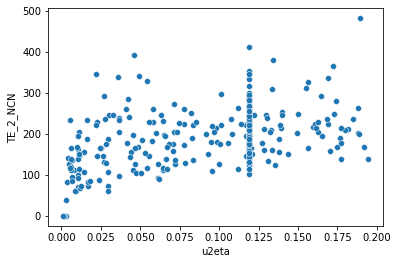

In [15]:
resultDataframeC1 = resultDataframeC[resultDataframeC['u2eta']<0.2]
sns.scatterplot(
    data=resultDataframeC1,
    x="u2eta",
    y="TE_2_NCN",
)